# Train an MLP, and run inference on testing data

**In this notebook we will cover the following:**

0. Data Ingestion and Filtering (Extract seismic at wellbore)
1. Feature Engineering
    * For data in those 8 well locations (not used for final training)
    * For augumented synthetic data (used for final training
2. Data Preparation for ML Model Training
3. Neural Network Model Training
4. Prediction at well locations

**This notebook assumes your AWS Credentials have been configured correctly**

In [2]:
# %%capture
# %pip install s3fs==0.5.0
# %pip install real-simple-seismic

In [1]:
from math import floor, ceil

from rss.client import rssFromS3
from pandas import concat, IndexSlice, read_csv, read_json
import pandas as pd

# Section 0. Data Ingestion and Filtering

### Read in the wells that we need to predict  (well 07 and well 13)

In [2]:
well_bucket = 's3://sagemaker-gitc2021/poseidon/wells/'
well_file = 'poseidon_geoml_testing_wells_blank.json.gz'

well_07_13_df = read_json(
    path_or_buf=well_bucket + well_file,
    compression='gzip',
)

well_07_13_df.set_index(['well_id', 'twt'], inplace=True)

well_07_13_df = well_07_13_df.rename(columns = {'p_impedance': 'dtc', 's_impedance': 'dts'})

well_07_13_df

inline      xline  rhob  dtc  dts
well_id twt                                         
well_07 2700.0  3256.5233  1389.3571   NaN  NaN  NaN
        2700.5  3256.5234  1389.3559   NaN  NaN  NaN
        2701.0  3256.5236  1389.3547   NaN  NaN  NaN
        2701.5  3256.5237  1389.3535   NaN  NaN  NaN
        2702.0  3256.5238  1389.3523   NaN  NaN  NaN
...                   ...        ...   ...  ...  ...
well_13 3383.5  2407.1952  2675.8771   NaN  NaN  NaN
        3384.0  2407.1905  2675.8925   NaN  NaN  NaN
        3384.5  2407.1858  2675.9078   NaN  NaN  NaN
        3385.0  2407.1811  2675.9232   NaN  NaN  NaN
        3385.5  2407.1763  2675.9386   NaN  NaN  NaN

[1773 rows x 5 columns]

### Read in the 6 known wells

In [3]:
well_bucket = 's3://sagemaker-gitc2021/poseidon/wells/'
well_file = 'poseidon_geoml_training_wells.json.gz'

well_df = read_json(
    path_or_buf=well_bucket + well_file,
    compression='gzip',
)

well_df.set_index(['well_id', 'twt'], inplace=True)
well_df = well_df[['inline', 'xline', 'rhob', 'dtc', 'dts']]
well_df

inline      xline    rhob      dtc       dts
well_id twt                                                    
well_01 1136.5  2992.8834  2202.6259     NaN  58.3867       NaN
        1137.0  2992.8834  2202.6259     NaN  58.4215       NaN
        1137.5  2992.8834  2202.6258     NaN  58.4564       NaN
        1138.0  2992.8834  2202.6258     NaN  58.4912       NaN
        1138.5  2992.8834  2202.6258     NaN  58.5260       NaN
...                   ...        ...     ...      ...       ...
well_33 3275.5  3184.5065  2347.5496  2.5694  67.4372  104.0350
        3276.0  3184.5094  2347.5584  2.5828  72.2925  109.3575
        3276.5  3184.5122  2347.5671  2.4341  68.8159  104.5286
        3277.0  3184.5150  2347.5758  2.3997  71.4051  105.4713
        3277.5  3184.5178  2347.5846  2.4335      NaN       NaN

[14824 rows x 5 columns]

### Merge both known and unkowned well dataframes into a combined dataframe

In [4]:
well_merge_df = pd.concat([well_df, well_07_13_df], axis = 0)
well_merge_df

inline      xline  rhob      dtc  dts
well_id twt                                             
well_01 1136.5  2992.8834  2202.6259   NaN  58.3867  NaN
        1137.0  2992.8834  2202.6259   NaN  58.4215  NaN
        1137.5  2992.8834  2202.6258   NaN  58.4564  NaN
        1138.0  2992.8834  2202.6258   NaN  58.4912  NaN
        1138.5  2992.8834  2202.6258   NaN  58.5260  NaN
...                   ...        ...   ...      ...  ...
well_13 3383.5  2407.1952  2675.8771   NaN      NaN  NaN
        3384.0  2407.1905  2675.8925   NaN      NaN  NaN
        3384.5  2407.1858  2675.9078   NaN      NaN  NaN
        3385.0  2407.1811  2675.9232   NaN      NaN  NaN
        3385.5  2407.1763  2675.9386   NaN      NaN  NaN

[16597 rows x 5 columns]

### Read in the seismic and velocity data at these well locations

In [5]:
%%time


'''
Get well names and separate `DataFrame` per well, and put in a dictionary.
We also build inline / crossline ranges (min/max) for each well here. This will give us the range to
query from the seismic data.
'''
well_names = well_df.index.levels[0].to_list() + well_07_13_df.index.levels[0].to_list()
num_wells = len(well_names)
print(well_names)

wells = {}
il_ranges = {}
xl_ranges = {}
for well_name in well_names:
    well = well_merge_df.loc[well_name]
    well_ils_xls = well[['inline', 'xline']]
    il_xl_min = well_ils_xls.min()
    il_xl_max = well_ils_xls.max()

    wells[well_name] = well
    il_ranges[well_name] = floor(il_xl_min[0]), ceil(il_xl_max[0])
    xl_ranges[well_name] = floor(il_xl_min[1]), ceil(il_xl_max[1])

'''
Now, we need to extract seismic values around the wellbore. Let's start with
mounting `real-simple-seismic` volumes of interest so we can query later.
**Poseidon data vertical sampling is between 0 and 6,000 milliseconds.**
**Seismic is sampled every 4 ms, and velocities are sampled every 10 ms.**
'''
seismic_bucket = r's3://sagemaker-gitc2021/poseidon/seismic/rss/'

seismic_files = [
    'psdn11_TbsdmF_Near_Nov_11_32bit',  # near angle stack (AVO)
    'psdn11_TbsdmF_Mid_Nov_11_32bit',  # mid angle stack (AVO)
    'psdn11_TbsdmF_Far_Nov_11_32bit',  # far angle stack (AVO)
    'Final_PSDM_intVel_gridded_D2T_10ms',  # PSDM interval velocities in time
]

'''
We loop through all files, and make connections to all four.
This takes about a minute.
The handles are later used for querying.
'''
rss_handles = []
for seismic_file in seismic_files:
    current_rss = rssFromS3(filename=seismic_bucket + seismic_file, client_kwargs={})

    rss_handles.append(current_rss)
    
from itertools import product
import numpy as np

# let's have nicer names for seismic data
seismic_names = ('near', 'mid', 'far', 'velocity')

well_seismic = {}
for well in wells.keys():
    il_min, il_max = il_ranges[well]
    xl_min, xl_max = xl_ranges[well]

    ils = range(il_min, il_max + 1, 1)  # inline increment is 1
    xls = range(xl_min, xl_max + 1, 1)  # xline increment is 1

    # Use product to have all il/xl pairs within our ranges
    ilxl_pairs = list(product(ils, xls))

    cube_data = {}
    # In rss, for minicube extraction we query trace by trace.
    for rss_handle, seismic_name in zip(rss_handles, seismic_names):
        tmp = []
        for trace_ilxl in ilxl_pairs:
            tmp.append(rss_handle.trace(*trace_ilxl)[0])  # rss returns values and a live mask, we don't need the mask now

        # Traces aren't in a "cube" shape, they come sequential. So we reshape!
        cube_data[seismic_name] = np.asarray(tmp).reshape(len(ils), len(xls), -1)

    well_seismic[well] = cube_data

Connection complete.
CPU times: user 18.7 s, sys: 3.66 s, total: 22.3 s
Wall time: 1min 10s


# Section 1. Feature Engineering

Let's begin with loading some libraries

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import hilbert, chirp
from sklearn.preprocessing import MinMaxScaler
sns.set(style="darkgrid")

# Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras as k

## For data in those 8 well locations (not used for final training)

### Extract near, mid, far and velocity stack data for each well and save into independent variables.

In [7]:
near_01 = well_seismic['well_01']['near']
near_11 = well_seismic['well_11']['near']
near_21 = well_seismic['well_21']['near']
near_25 = well_seismic['well_25']['near']
near_27 = well_seismic['well_27']['near']
near_33 = well_seismic['well_33']['near']
near_07 = well_seismic['well_07']['near']
near_13 = well_seismic['well_13']['near']

In [8]:
mid_01 = well_seismic['well_01']['mid']
mid_11 = well_seismic['well_11']['mid']
mid_21 = well_seismic['well_21']['mid']
mid_25 = well_seismic['well_25']['mid']
mid_27 = well_seismic['well_27']['mid']
mid_33 = well_seismic['well_33']['mid']
mid_07 = well_seismic['well_07']['mid']
mid_13 = well_seismic['well_13']['mid']

In [9]:
far_01 = well_seismic['well_01']['far']
far_11 = well_seismic['well_11']['far']
far_21 = well_seismic['well_21']['far']
far_25 = well_seismic['well_25']['far']
far_27 = well_seismic['well_27']['far']
far_33 = well_seismic['well_33']['far']
far_07 = well_seismic['well_07']['far']
far_13 = well_seismic['well_13']['far']

In [10]:
velocity_01 = well_seismic['well_01']['velocity']
velocity_11 = well_seismic['well_11']['velocity']
velocity_21 = well_seismic['well_21']['velocity']
velocity_25 = well_seismic['well_25']['velocity']
velocity_27 = well_seismic['well_27']['velocity']
velocity_33 = well_seismic['well_33']['velocity']
velocity_07 = well_seismic['well_07']['velocity']
velocity_13 = well_seismic['well_13']['velocity']

In [11]:
near_01.shape, mid_01.shape, far_01.shape, velocity_01.shape

((3, 9, 1501), (3, 9, 1501), (3, 9, 1501), (3, 9, 601))

### Now we will average all of the traces into one array. Let's stick these in a list for later processing. 

In [12]:
# Average all IL/XL into a single array and create pd dataframes 
near_01_composite = pd.DataFrame(np.mean((np.mean(near_01,axis=1)), axis=0), columns=['near_01_composite'])
near_11_composite = pd.DataFrame(np.mean((np.mean(near_11,axis=1)), axis=0), columns=['near_11_composite'])
near_21_composite = pd.DataFrame(np.mean((np.mean(near_21,axis=1)), axis=0), columns=['near_21_composite'])
near_25_composite = pd.DataFrame(np.mean((np.mean(near_25,axis=1)), axis=0), columns=['near_25_composite'])
near_27_composite = pd.DataFrame(np.mean((np.mean(near_27,axis=1)), axis=0), columns=['near_27_composite'])
near_33_composite = pd.DataFrame(np.mean((np.mean(near_33,axis=1)), axis=0), columns=['near_33_composite'])
near_07_composite = pd.DataFrame(np.mean((np.mean(near_07,axis=1)), axis=0), columns=['near_07_composite'])
near_13_composite = pd.DataFrame(np.mean((np.mean(near_13,axis=1)), axis=0), columns=['near_13_composite'])

composite_data_near = [near_01_composite, near_11_composite, near_21_composite, near_25_composite, \
                       near_27_composite, near_33_composite, near_07_composite, near_13_composite]

mid_01_composite = pd.DataFrame(np.mean((np.mean(mid_01,axis=1)), axis=0), columns=['mid_01_composite'])
mid_11_composite = pd.DataFrame(np.mean((np.mean(mid_11,axis=1)), axis=0), columns=['mid_11_composite'])
mid_21_composite = pd.DataFrame(np.mean((np.mean(mid_21,axis=1)), axis=0), columns=['mid_21_composite'])
mid_25_composite = pd.DataFrame(np.mean((np.mean(mid_25,axis=1)), axis=0), columns=['mid_25_composite'])
mid_27_composite = pd.DataFrame(np.mean((np.mean(mid_27,axis=1)), axis=0), columns=['mid_27_composite'])
mid_33_composite = pd.DataFrame(np.mean((np.mean(mid_33,axis=1)), axis=0), columns=['mid_33_composite'])
mid_07_composite = pd.DataFrame(np.mean((np.mean(mid_07,axis=1)), axis=0), columns=['mid_07_composite'])
mid_13_composite = pd.DataFrame(np.mean((np.mean(mid_13,axis=1)), axis=0), columns=['mid_13_composite'])


composite_data_mid = [mid_01_composite, mid_11_composite, mid_21_composite, mid_25_composite, \
                      mid_27_composite, mid_33_composite, mid_07_composite, mid_13_composite]

far_01_composite = pd.DataFrame(np.mean((np.mean(far_01,axis=1)), axis=0), columns=['far_01_composite'])
far_11_composite = pd.DataFrame(np.mean((np.mean(far_11,axis=1)), axis=0), columns=['far_11_composite'])
far_21_composite = pd.DataFrame(np.mean((np.mean(far_21,axis=1)), axis=0), columns=['far_21_composite'])
far_25_composite = pd.DataFrame(np.mean((np.mean(far_25,axis=1)), axis=0), columns=['far_25_composite'])
far_27_composite = pd.DataFrame(np.mean((np.mean(far_27,axis=1)), axis=0), columns=['far_27_composite'])
far_33_composite = pd.DataFrame(np.mean((np.mean(far_33,axis=1)), axis=0), columns=['far_33_composite'])
far_07_composite = pd.DataFrame(np.mean((np.mean(far_07,axis=1)), axis=0), columns=['far_07_composite'])
far_13_composite = pd.DataFrame(np.mean((np.mean(far_13,axis=1)), axis=0), columns=['far_13_composite'])

composite_data_far = [far_01_composite, far_11_composite, far_21_composite, far_25_composite, \
                      far_27_composite, far_33_composite, far_07_composite, far_13_composite]


velocity_01_composite = pd.DataFrame(np.mean((np.mean(velocity_01,axis=1)), axis=0), columns=['velocity_01_composite'])
velocity_11_composite = pd.DataFrame(np.mean((np.mean(velocity_11,axis=1)), axis=0), columns=['velocity_11_composite'])
velocity_21_composite = pd.DataFrame(np.mean((np.mean(velocity_21,axis=1)), axis=0), columns=['velocity_21_composite'])
velocity_25_composite = pd.DataFrame(np.mean((np.mean(velocity_25,axis=1)), axis=0), columns=['velocity_25_composite'])
velocity_27_composite = pd.DataFrame(np.mean((np.mean(velocity_27,axis=1)), axis=0), columns=['velocity_27_composite'])
velocity_33_composite = pd.DataFrame(np.mean((np.mean(velocity_33,axis=1)), axis=0), columns=['velocity_33_composite'])
velocity_07_composite = pd.DataFrame(np.mean((np.mean(velocity_07,axis=1)), axis=0), columns=['velocity_07_composite'])
velocity_13_composite = pd.DataFrame(np.mean((np.mean(velocity_13,axis=1)), axis=0), columns=['velocity_13_composite'])

composite_data_velocity = [velocity_01_composite, velocity_11_composite, velocity_21_composite, velocity_25_composite,\
                           velocity_27_composite, velocity_33_composite, velocity_07_composite, velocity_13_composite]



#### Create the two-way-time indices for the training DataFrame.

#### We will interpolate seismic traces using `cubic` interpolation to the same sample rate as the well data, which is every 0.5 ms two-way-time.

#### If you recall:

*Poseidon data vertical sampling is between 0 and 6,000 milliseconds.*

*Seismic is sampled every 4 ms, and velocities are sampled every 10 ms.*


In [13]:
# index at 10ms 
velocity_twt = pd.DataFrame(np.arange(0, 6010.0, 10.0), columns=['twt'])

# index at 4ms 
seismic_twt = pd.DataFrame(np.arange(0, 6004.0, 4.0), columns=['twt'])

# index at .5 ms 
resamp_twt = pd.DataFrame(np.arange(0, 6000.5, 0.5), columns=['twt'])

#### Combine all the velocity data into one dataframe

In [14]:
data_velocity_concat = []
data_velocity_concat.append(velocity_twt)
data_velocity_concat.extend(composite_data_velocity)

In [15]:
tt_velocity = pd.concat(data_velocity_concat, axis=1)
velocity_concat_resamp_raw = tt_velocity.merge(resamp_twt, how='right', on=['twt'])
velocity_concat_resamp_interp = velocity_concat_resamp_raw.interpolate(method='cubic', limit_direction='forward', axis=0)
velocity_concat_resamp_interp

,twt,velocity_01_composite,velocity_11_composite,velocity_21_composite,velocity_25_composite,velocity_27_composite,velocity_33_composite,velocity_07_composite,velocity_13_composite
0,0.0,1523.470219,1523.452544,1523.463996,1523.462119,1523.447081,1523.457274,1523.457274,1523.474049
1,0.5,1523.470526,1523.452804,1523.464278,1523.462399,1523.447341,1523.457536,1523.457536,1523.474335
2,1.0,1523.470786,1523.453025,1523.464516,1523.462637,1523.447561,1523.457757,1523.457757,1523.474576
3,1.5,1523.471001,1523.453208,1523.464714,1523.462833,1523.447743,1523.457940,1523.457940,1523.474776
4,2.0,1523.471174,1523.453355,1523.464872,1523.462991,1523.447889,1523.458087,1523.458087,1523.474937
...,...,...,...,...,...,...,...,...,...
11996,5998.0,5227.339589,5326.513956,5188.513820,5104.419643,5226.641092,5281.244586,5135.776411,5245.480989
11997,5998.5,5227.341835,5326.514313,5188.515502,5104.422004,5226.638413,5281.246909,5135.765239,5245.481672
11998,5999.0,5227.344453,5326.514823,5188.517487,5104.424868,5226.635452,5281.249644,5135.753105,5245.482267
11999,5999.5,5227.347458,5326.515494,5188.519791,5104.428261,5226.632199,5281.252811,5135.739978,5245.482768


#### Combine all the seismic data into one dataframe

In [21]:
data_seismic_concat = []
data_seismic_concat.append(seismic_twt)
data_seismic_concat.extend(composite_data_near)
data_seismic_concat.extend(composite_data_mid)
data_seismic_concat.extend(composite_data_far)

In [22]:
# DataFrames to concatenate 

tt_seismic = pd.concat(data_seismic_concat, axis=1)

# Here we merge our seismic to the resamp 'twt' array
sesimic_concat_resamp_raw = tt_seismic.merge(resamp_twt, how='right', on=['twt'])

# Here we interpolate the gaps in the seismic after the resamp
seismic_concat_resamp_interp = sesimic_concat_resamp_raw.interpolate(method='cubic', limit_direction='forward', axis=0)

#let's look at the result
seismic_concat_resamp_interp

,twt,near_01_composite,near_11_composite,near_21_composite,near_25_composite,near_27_composite,near_33_composite,near_07_composite,near_13_composite,mid_01_composite,...,mid_07_composite,mid_13_composite,far_01_composite,far_11_composite,far_21_composite,far_25_composite,far_27_composite,far_33_composite,far_07_composite,far_13_composite
0,0.0,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084,-3.686249,-1.837291,-2.177104,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
1,0.5,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084,-3.686249,-1.837291,-2.177104,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
2,1.0,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084,-3.686249,-1.837291,-2.177104,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
3,1.5,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084,-3.686249,-1.837291,-2.177104,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
4,2.0,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084,-3.686249,-1.837291,-2.177104,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11996,5998.0,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084,-3.686249,-1.837291,-2.177104,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
11997,5998.5,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084,-3.686249,-1.837291,-2.177104,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
11998,5999.0,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084,-3.686249,-1.837291,-2.177104,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
11999,5999.5,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084,-3.686249,-1.837291,-2.177104,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535


#### Combine both velocity and seismic data into one dataframe

In [23]:
data_concat_resamp_interp = pd.concat([velocity_concat_resamp_interp,seismic_concat_resamp_interp.drop(columns = 'twt')], axis = 1)
data_concat_resamp_interp

,twt,velocity_01_composite,velocity_11_composite,velocity_21_composite,velocity_25_composite,velocity_27_composite,velocity_33_composite,velocity_07_composite,velocity_13_composite,near_01_composite,...,mid_07_composite,mid_13_composite,far_01_composite,far_11_composite,far_21_composite,far_25_composite,far_27_composite,far_33_composite,far_07_composite,far_13_composite
0,0.0,1523.470219,1523.452544,1523.463996,1523.462119,1523.447081,1523.457274,1523.457274,1523.474049,-2.459141,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
1,0.5,1523.470526,1523.452804,1523.464278,1523.462399,1523.447341,1523.457536,1523.457536,1523.474335,-2.459141,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
2,1.0,1523.470786,1523.453025,1523.464516,1523.462637,1523.447561,1523.457757,1523.457757,1523.474576,-2.459141,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
3,1.5,1523.471001,1523.453208,1523.464714,1523.462833,1523.447743,1523.457940,1523.457940,1523.474776,-2.459141,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
4,2.0,1523.471174,1523.453355,1523.464872,1523.462991,1523.447889,1523.458087,1523.458087,1523.474937,-2.459141,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11996,5998.0,5227.339589,5326.513956,5188.513820,5104.419643,5226.641092,5281.244586,5135.776411,5245.480989,-2.459141,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
11997,5998.5,5227.341835,5326.514313,5188.515502,5104.422004,5226.638413,5281.246909,5135.765239,5245.481672,-2.459141,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
11998,5999.0,5227.344453,5326.514823,5188.517487,5104.424868,5226.635452,5281.249644,5135.753105,5245.482267,-2.459141,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535
11999,5999.5,5227.347458,5326.515494,5188.519791,5104.428261,5226.632199,5281.252811,5135.739978,5245.482768,-2.459141,...,-1.023616,-1.353598,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823,-1.349676,-1.478535


#### Here we make a copy of wells to not corrupt the original dataframe.

In [24]:
well_no_list = ['01', '11', '21', '25', '27', '33', '07', '13']
seismic_near_mid_far_velocity = ['near', 'mid', 'far', 'velocity']

In [25]:
seismic_list = []
for item1 in well_no_list:
    for item2 in seismic_near_mid_far_velocity:
        temp = item2 + '_' + item1 + '_' + 'composite'
        seismic_list.append(temp)
        print(temp)
        

near_01_composite
mid_01_composite
far_01_composite
velocity_01_composite
near_11_composite
mid_11_composite
far_11_composite
velocity_11_composite
near_21_composite
mid_21_composite
far_21_composite
velocity_21_composite
near_25_composite
mid_25_composite
far_25_composite
velocity_25_composite
near_27_composite
mid_27_composite
far_27_composite
velocity_27_composite
near_33_composite
mid_33_composite
far_33_composite
velocity_33_composite
near_07_composite
mid_07_composite
far_07_composite
velocity_07_composite
near_13_composite
mid_13_composite
far_13_composite
velocity_13_composite


In [26]:
composite_resamp_list = []

for item in seismic_list:
    composite_resamp_list.append(data_concat_resamp_interp[['twt',item]].copy())

In [27]:
well_01 = well_merge_df.loc['well_01'].reset_index()
well_11 = well_merge_df.loc['well_11'].reset_index()
well_21 = well_merge_df.loc['well_21'].reset_index()
well_25 = well_merge_df.loc['well_25'].reset_index()
well_27 = well_merge_df.loc['well_27'].reset_index()
well_33 = well_merge_df.loc['well_33'].reset_index()
well_07 = well_merge_df.loc['well_07'].reset_index()
well_13 = well_merge_df.loc['well_13'].reset_index()

#### Add appropriate targets P-Impedance (here, called Zp) and S-Impedance (here, called Zs). 

In [28]:
#calculate impedances and add to data 
# well_01
well_01['Zp'] = (1000000/well_01['dtc'])*well_01['rhob']
well_01['Zs'] = (1000000/well_01['dts'])*well_01['rhob']
well_01['vp'] = 1000000/well_01['dtc']
# well_11
well_11['Zp'] = (1000000/well_11['dtc'])*well_11['rhob']
well_11['Zs'] = (1000000/well_11['dts'])*well_11['rhob']
well_11['vp'] = 1000000/well_11['dtc']
# well_21
well_21['Zp'] = (1000000/well_21['dtc'])*well_21['rhob']
well_21['Zs'] = (1000000/well_21['dts'])*well_21['rhob']
well_21['vp'] = 1000000/well_21['dtc']
# well_25
well_25['Zp'] = (1000000/well_25['dtc'])*well_25['rhob']
well_25['Zs'] = (1000000/well_25['dts'])*well_25['rhob']
well_25['vp'] = 1000000/well_25['dtc']
# well_27
well_27['Zp'] = (1000000/well_27['dtc'])*well_27['rhob']
well_27['Zs'] = (1000000/well_27['dts'])*well_27['rhob']
well_27['vp'] = 1000000/well_27['dtc']
# well_33
well_33['Zp'] = (1000000/well_33['dtc'])*well_33['rhob']
well_33['Zs'] = (1000000/well_33['dts'])*well_33['rhob']
well_33['vp'] = 1000000/well_33['dtc']

well_07['Zp'] = (1000000/well_07['dtc'])*well_07['rhob']
well_07['Zs'] = (1000000/well_07['dts'])*well_07['rhob']
well_07['vp'] = 1000000/well_07['dtc']

well_13['Zp'] = (1000000/well_13['dtc'])*well_13['rhob']
well_13['Zs'] = (1000000/well_13['dts'])*well_13['rhob']
well_13['vp'] = 1000000/well_13['dtc']

In [29]:
# Lets filter the well data and keep only the relevant columns
well_01_stripped = well_01[['twt','Zp','Zs','rhob', 'vp']].copy()
well_11_stripped = well_11[['twt','Zp','Zs','rhob', 'vp']].copy()
well_21_stripped = well_21[['twt','Zp','Zs','rhob', 'vp']].copy()
well_25_stripped = well_25[['twt','Zp','Zs','rhob', 'vp']].copy()
well_27_stripped = well_27[['twt','Zp','Zs','rhob', 'vp']].copy()
well_33_stripped = well_33[['twt','Zp','Zs','rhob', 'vp']].copy()
well_07_stripped = well_07[['twt','Zp','Zs','rhob', 'vp']].copy()
well_13_stripped = well_13[['twt','Zp','Zs','rhob', 'vp']].copy()

In [30]:
well_stripped_list = [well_01_stripped, well_11_stripped, well_21_stripped, well_25_stripped,\
                      well_27_stripped, well_33_stripped, well_07_stripped, well_13_stripped]

#### Now we need to merge these two on the twt column - this gives us the association in twt of the well data and the composite trace. This is where good well-ties plays the most important role. 

In [31]:
tt_independent_wells = []

for i, item in enumerate(well_no_list):
    temp_well = well_stripped_list[i].copy()
    for j in range(i*4,i*4+4):
        temp_well = temp_well.merge(composite_resamp_list[j], how = 'right', on = ['twt'])
    temp_well['well_name'] = ['well'+'_'+item]*len(temp_well)
    print('well'+'_'+item)
    temp_well.set_index(['well_name'], inplace=True)
    column_names = list(temp_well.columns)
    temp_well.rename({column_names[5]: "near_composite", column_names[6]: "mid_composite", column_names[7]: "far_composite", column_names[8]: "velocity_composite"}, axis = 'columns', inplace=True)
    tt_independent_wells.append(temp_well)
        

well_01
well_11
well_21
well_25
well_27
well_33
well_07
well_13


In [32]:
tt_independent_wells[1]

,twt,Zp,Zs,rhob,vp,near_composite,mid_composite,far_composite,velocity_composite
well_name,,,,,,,,,
well_11,0.0,NaN,NaN,NaN,NaN,-0.359645,-3.05652,-1.788095,1523.452544
well_11,0.5,NaN,NaN,NaN,NaN,-0.359645,-3.05652,-1.788095,1523.452804
well_11,1.0,NaN,NaN,NaN,NaN,-0.359645,-3.05652,-1.788095,1523.453025
well_11,1.5,NaN,NaN,NaN,NaN,-0.359645,-3.05652,-1.788095,1523.453208
well_11,2.0,NaN,NaN,NaN,NaN,-0.359645,-3.05652,-1.788095,1523.453355
...,...,...,...,...,...,...,...,...,...
well_11,5998.0,NaN,NaN,NaN,NaN,-0.359645,-3.05652,-1.788095,5326.513956
well_11,5998.5,NaN,NaN,NaN,NaN,-0.359645,-3.05652,-1.788095,5326.514313
well_11,5999.0,NaN,NaN,NaN,NaN,-0.359645,-3.05652,-1.788095,5326.514823


#### Let's take a look at how the calculated vp compared with given velocities at these well locations

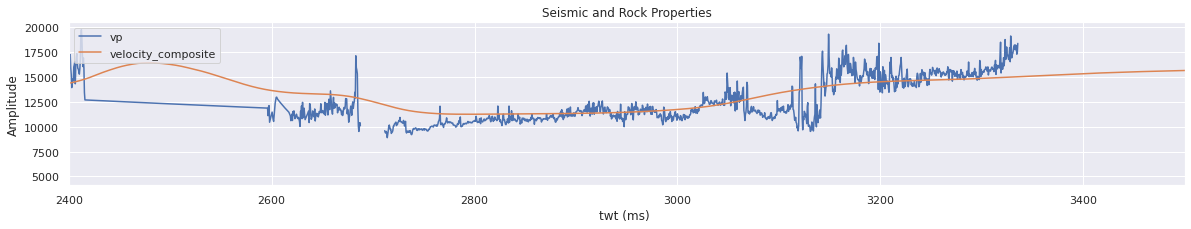

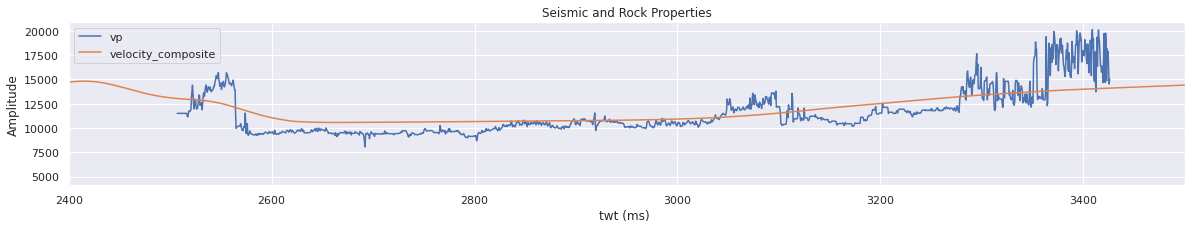

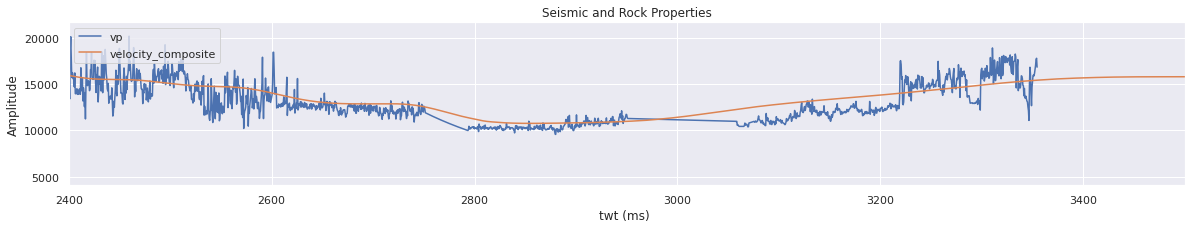

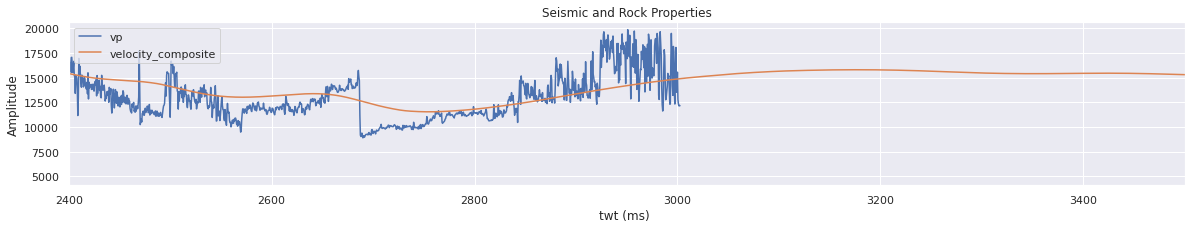

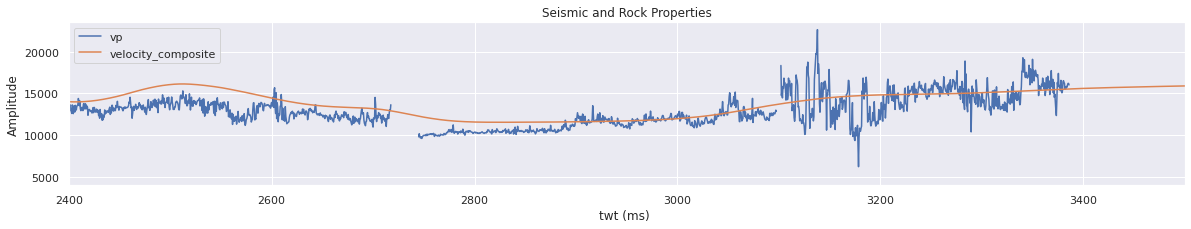

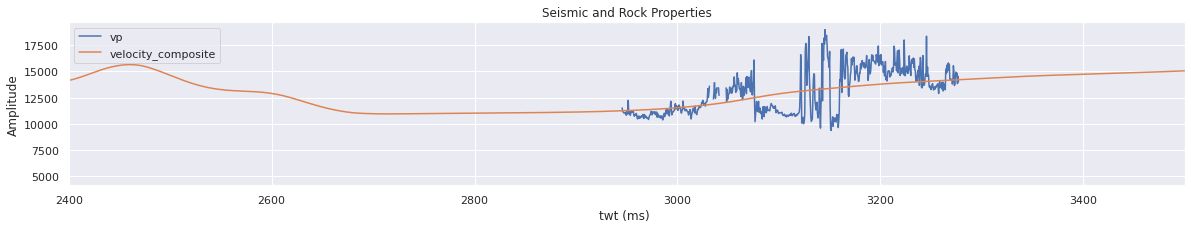

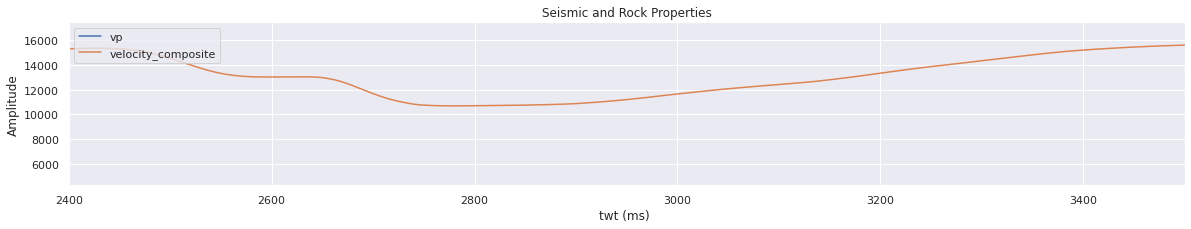

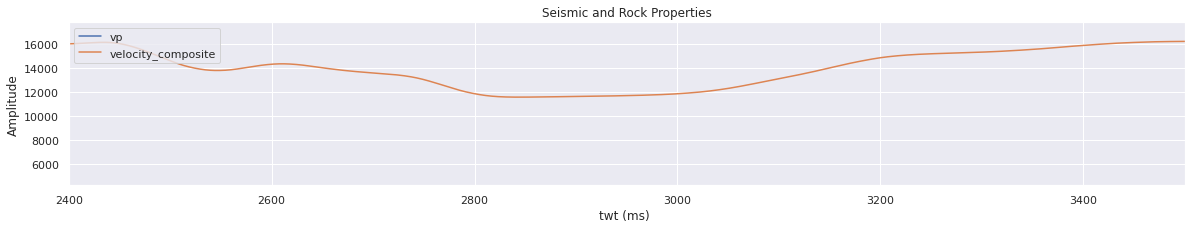

In [33]:
for tt_wells in tt_independent_wells:
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(0,6000.5,.5), tt_wells['vp'])
    plt.plot(np.arange(0,6000.5,.5), tt_wells['velocity_composite'] *3.28084)
    plt.title('Seismic and Rock Properties')
#     plt.ylim(-100000,100000)
    plt.xlim(2400,3500)
#     plt.xlim(0,6000)
    plt.xlabel('twt (ms) ')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper left', labels =['vp', 'velocity_composite'])

### Now seperate the wells into training and testing groups for later usage

In [34]:
training_wells = tt_independent_wells[0:6]
testing_wells = tt_independent_wells[6:]

In [35]:
testing_wells[0]

,twt,Zp,Zs,rhob,vp,near_composite,mid_composite,far_composite,velocity_composite
well_name,,,,,,,,,
well_07,0.0,NaN,NaN,NaN,NaN,-3.686249,-1.023616,-1.349676,1523.457274
well_07,0.5,NaN,NaN,NaN,NaN,-3.686249,-1.023616,-1.349676,1523.457536
well_07,1.0,NaN,NaN,NaN,NaN,-3.686249,-1.023616,-1.349676,1523.457757
well_07,1.5,NaN,NaN,NaN,NaN,-3.686249,-1.023616,-1.349676,1523.457940
well_07,2.0,NaN,NaN,NaN,NaN,-3.686249,-1.023616,-1.349676,1523.458087
...,...,...,...,...,...,...,...,...,...
well_07,5998.0,NaN,NaN,NaN,NaN,-3.686249,-1.023616,-1.349676,5135.776411
well_07,5998.5,NaN,NaN,NaN,NaN,-3.686249,-1.023616,-1.349676,5135.765239
well_07,5999.0,NaN,NaN,NaN,NaN,-3.686249,-1.023616,-1.349676,5135.753105


### Prepare the trainning datasets and testing datasets. In this notebook, we did not use training datasets here directly from those wells. Instead, we used augamented synthetic (shown later) as training dataset. However, this training dataset can be added as well.

In [36]:
features = ['twt','near_composite', 'mid_composite', 'far_composite', 'velocity_composite']
targets = ['Zp','Zs','rhob']

# Here we concat all of the training wells and drop rows with nans
training_wells_tt = pd.concat(training_wells)
training_wells_tt = training_wells_tt.dropna()

# Here we shuffle the data
training_wells_tt = training_wells_tt.sample(frac=1)

# Here we seperate into inputs and targets 
X_train = training_wells_tt[features]
y_train = training_wells_tt[targets]

# Print for QC
print('training inputs:', X_train)
print('training targets:',y_train)

# Here we drop rows with nans in testing data
testing_well_tt = pd.concat(testing_wells)
# testing_well_tt = testing_well_tt.dropna()

# Here we seperate into inputs and targets 
X_test = testing_well_tt[features]
y_test = testing_well_tt[targets]

# Print for QC
print('testing inputs:', X_test)
print('testing targets:',y_test)

training inputs:               twt  near_composite  mid_composite  far_composite  \
well_name                                                         
well_11    2603.0    -9734.392790    1475.923031    3514.761294   
well_33    3051.5   -14439.421674   -6720.999257    1076.307062   
well_01    3316.0    -7707.368469   -4553.413748    1304.621301   
well_11    2731.5    -4724.155274   -2195.918959    2834.056969   
well_25    2936.5    22550.805654   16909.627225    9727.308161   
...           ...             ...            ...            ...   
well_27    3233.5     -438.346588   14062.915848   11806.465344   
well_11    2588.0     -562.741212   -5304.666955   -6034.442756   
well_11    3136.0    -6426.066436    2574.790228    -167.533810   
well_11    3137.0    -6311.955846    3174.201654    -308.134030   
well_11    2609.0      923.000046    7396.573449   10216.859554   

           velocity_composite  
well_name                      
well_11           3347.836354  
well_33        

## For augumented synthetic data (used for final training)

### Read in augumented synthetic seismic data

In [39]:
synthetic_seismic_df = pd.read_csv('synthetic_seismic_new_0425.csv')
synthetic_seismic_df = synthetic_seismic_df.set_index('well_name')
synthetic_seismic_df = synthetic_seismic_df.drop(columns = ['Unnamed: 0'])
print(synthetic_seismic_df.shape)
synthetic_seismic_df

(907452, 6)


,twt,inline,xline,near_composite,mid_composite,velocity_composite
well_name,,,,,,
synthetic,1800.0,2405,1391,-985.6279,127.35925,3692.045259
synthetic,1800.5,2405,1391,1054.9170,1782.06840,3697.428841
synthetic,1801.0,2405,1391,3534.4783,3791.22440,3702.852790
synthetic,1801.5,2405,1391,6353.7420,6073.47660,3708.315649
synthetic,1802.0,2405,1391,9383.9530,8523.51600,3713.815957
...,...,...,...,...,...,...
synthetic,3598.0,3255,2691,14575.6170,8285.53900,4171.824062
synthetic,3598.5,3255,2691,15473.5700,9094.25800,4172.551102
synthetic,3599.0,3255,2691,15859.2460,9554.64100,4173.279380


### Make some more features

In [40]:
for item in ['near_composite', 'mid_composite']:
    print(item)
    analytic_signal = hilbert(synthetic_seismic_df[item])
    synthetic_seismic_df[item+'_HTEnv'] = np.abs(analytic_signal)
    synthetic_seismic_df[item+'_HTEnvCosPhs'] = np.cos(np.angle(analytic_signal)) * synthetic_seismic_df[item+'_HTEnv']
    synthetic_seismic_df[item+'_GradTrail5'] = synthetic_seismic_df[item].diff(periods=-5)
    synthetic_seismic_df[item+'_GradLead5'] = synthetic_seismic_df[item].diff(periods=5)
    synthetic_seismic_df[item+'_GradTrail10'] = synthetic_seismic_df[item].diff(periods=-10)
    synthetic_seismic_df[item+'_GradLead10'] = synthetic_seismic_df[item].diff(periods=10)

near_composite
mid_composite


In [41]:
synthetic_seismic_df = synthetic_seismic_df.fillna(0)
synthetic_seismic_df

,twt,inline,xline,near_composite,mid_composite,velocity_composite,near_composite_HTEnv,near_composite_HTEnvCosPhs,near_composite_GradTrail5,near_composite_GradLead5,near_composite_GradTrail10,near_composite_GradLead10,mid_composite_HTEnv,mid_composite_HTEnvCosPhs,mid_composite_GradTrail5,mid_composite_GradLead5,mid_composite_GradTrail10,mid_composite_GradLead10
well_name,,,,,,,,,,,,,,,,,,
synthetic,1800.0,2405,1391,-985.6279,127.35925,3692.045259,6910.059058,-985.6279,-13459.2019,0.0000,-23759.0849,0.0000,1273.099884,127.35925,-10890.15675,0.0000,-19087.10975,0.0000
synthetic,1800.5,2405,1391,1054.9170,1782.06840,3697.428841,4888.169431,1054.9170,-14401.4850,0.0000,-21742.9580,0.0000,6040.599502,1782.06840,-11637.66560,0.0000,-17396.54860,0.0000
synthetic,1801.0,2405,1391,3534.4783,3791.22440,3702.852790,6201.819610,3534.4783,-14626.3117,0.0000,-18438.7557,0.0000,7103.865974,3791.22440,-11798.82660,0.0000,-14654.47060,0.0000
synthetic,1801.5,2405,1391,6353.7420,6073.47660,3708.315649,10536.193570,6353.7420,-14065.5860,0.0000,-13929.3050,0.0000,9967.399237,6073.47660,-11318.36740,0.0000,-10928.81640,0.0000
synthetic,1802.0,2405,1391,9383.9530,8523.51600,3713.815957,12039.653968,9383.9530,-12568.2770,0.0000,-8363.7500,0.0000,11148.746263,8523.51600,-10072.25400,0.0000,-6341.51500,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
synthetic,3598.0,3255,2691,14575.6170,8285.53900,4171.824062,17410.881694,14575.6170,0.0000,10156.4334,0.0000,22699.8436,11752.313748,8285.53900,0.00000,7697.1484,0.00000,16218.9570
synthetic,3598.5,3255,2691,15473.5700,9094.25800,4172.551102,17407.568967,15473.5700,0.0000,8606.4255,0.0000,21248.8940,11702.789348,9094.25800,0.00000,6727.5747,0.00000,15516.6680
synthetic,3599.0,3255,2691,15859.2460,9554.64100,4173.279380,16160.437481,15859.2460,0.0000,6588.7770,0.0000,19152.2567,10528.381448,9554.64100,0.00000,5413.5707,0.00000,14331.9730


### Read in augumented synthetic well logs

In [42]:
synthetic_log_df = pd.read_csv('synthetic_log_new_0425.csv')
synthetic_log_df = synthetic_log_df.set_index('well_name')
synthetic_log_df = synthetic_log_df.drop(columns = ['Unnamed: 0'])
print(synthetic_log_df.shape)
synthetic_log_df

(907452, 4)


,twt,Zp,Zs,rhob
well_name,,,,
synthetic,1800.0,7838.3555,4467.3320,1.735296
synthetic,1800.5,7960.6875,4568.4140,1.745203
synthetic,1801.0,8101.3203,4684.2188,1.756828
synthetic,1801.5,8251.0390,4807.1562,1.769448
synthetic,1802.0,8399.1950,4928.5470,1.782191
...,...,...,...,...
synthetic,3598.0,8525.1480,5191.0195,2.409767
synthetic,3598.5,8389.3950,5056.4883,2.393085
synthetic,3599.0,8257.6370,4928.3125,2.377434


### Do the same feature engineering on test dataset

In [43]:
# Add inline/xline number and twt into the features


X_test = X_test[['twt', 'near_composite', 'mid_composite', 'velocity_composite']]
X_test['inline'] = 3257
X_test['xline'] = 1389
X_test.loc['well_13']['inline'] = 2408
X_test.loc['well_13']['xline'] = 2671
X_test = X_test[['twt', 'inline', 'xline', 'near_composite', 'mid_composite', 'velocity_composite']]
X_test

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,twt,inline,xline,near_composite,mid_composite,velocity_composite
well_name,,,,,,
well_07,0.0,3257,1389,-3.686249,-1.023616,1523.457274
well_07,0.5,3257,1389,-3.686249,-1.023616,1523.457536
well_07,1.0,3257,1389,-3.686249,-1.023616,1523.457757
well_07,1.5,3257,1389,-3.686249,-1.023616,1523.457940
well_07,2.0,3257,1389,-3.686249,-1.023616,1523.458087
...,...,...,...,...,...,...
well_13,5998.0,2408,2671,-1.837291,-1.353598,5245.480989
well_13,5998.5,2408,2671,-1.837291,-1.353598,5245.481672
well_13,5999.0,2408,2671,-1.837291,-1.353598,5245.482267


### Make some more features on test dataset (same as on training data)

In [44]:
# Add those additional features

for item in ['near_composite', 'mid_composite']:
    print(item)
    analytic_signal = hilbert(X_test[item])
    X_test[item+'_HTEnv'] = np.abs(analytic_signal)
    X_test[item+'_HTEnvCosPhs'] = np.cos(np.angle(analytic_signal)) * X_test[item+'_HTEnv']
    X_test[item+'_GradTrail5'] = X_test[item].diff(periods=-5)
    X_test[item+'_GradLead5'] = X_test[item].diff(periods=5)
    X_test[item+'_GradTrail10'] = X_test[item].diff(periods=-10)
    X_test[item+'_GradLead10'] = X_test[item].diff(periods=10)
    
X_test = X_test.fillna(0)
X_test

near_composite
mid_composite


,twt,inline,xline,near_composite,mid_composite,velocity_composite,near_composite_HTEnv,near_composite_HTEnvCosPhs,near_composite_GradTrail5,near_composite_GradLead5,near_composite_GradTrail10,near_composite_GradLead10,mid_composite_HTEnv,mid_composite_HTEnvCosPhs,mid_composite_GradTrail5,mid_composite_GradLead5,mid_composite_GradTrail10,mid_composite_GradLead10
well_name,,,,,,,,,,,,,,,,,,
well_07,0.0,3257,1389,-3.686249,-1.023616,1523.457274,4.050024,-3.686249,4.440892e-16,0.000000e+00,8.881784e-16,0.000000e+00,2.308463,-1.023616,0.0,0.000000e+00,0.000000e+00,0.000000e+00
well_07,0.5,3257,1389,-3.686249,-1.023616,1523.457536,4.658338,-3.686249,-4.440892e-16,0.000000e+00,-8.881784e-16,0.000000e+00,2.121151,-1.023616,0.0,0.000000e+00,-2.220446e-16,0.000000e+00
well_07,1.0,3257,1389,-3.686249,-1.023616,1523.457757,4.654337,-3.686249,-4.440892e-16,0.000000e+00,-4.440892e-16,0.000000e+00,2.120086,-1.023616,0.0,0.000000e+00,-2.220446e-16,0.000000e+00
well_07,1.5,3257,1389,-3.686249,-1.023616,1523.457940,4.899425,-3.686249,-4.440892e-16,0.000000e+00,-4.440892e-16,0.000000e+00,2.057988,-1.023616,0.0,0.000000e+00,-2.220446e-16,0.000000e+00
well_07,2.0,3257,1389,-3.686249,-1.023616,1523.458087,4.895123,-3.686249,0.000000e+00,0.000000e+00,8.881784e-16,0.000000e+00,2.056936,-1.023616,0.0,0.000000e+00,2.220446e-16,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
well_13,5998.0,2408,2671,-1.837291,-1.353598,5245.480989,3.759462,-1.837291,0.000000e+00,0.000000e+00,0.000000e+00,2.220446e-16,2.248264,-1.353598,0.0,0.000000e+00,0.000000e+00,0.000000e+00
well_13,5998.5,2408,2671,-1.837291,-1.353598,5245.481672,3.753707,-1.837291,0.000000e+00,0.000000e+00,0.000000e+00,-4.440892e-16,2.247286,-1.353598,0.0,0.000000e+00,0.000000e+00,-2.220446e-16
well_13,5999.0,2408,2671,-1.837291,-1.353598,5245.482267,3.411405,-1.837291,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.302579,-1.353598,0.0,0.000000e+00,0.000000e+00,0.000000e+00


# Section 2. Data Preparation for ML Model Training

In [45]:
# Prepare X_train and Y_train

X_train = synthetic_seismic_df
y_train = synthetic_log_df[['Zp', 'Zs', 'rhob']]

### Input data normalization using minmax_scaler

In [46]:
def minmax_scaler(data, minmaxrange=(-1,1)):
    scaler = MinMaxScaler(feature_range = minmaxrange)
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

In [47]:
# Here we scale the training inputs and create the scaler to be used to scale testing data and for inverse transform after simulation
X_train_scaled, X_scaler = minmax_scaler(X_train, minmaxrange=(-1,1))
X_test_scaled = X_scaler.transform(X_test)

# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Here we do the same for the targets
y_train_scaled, y_scaler = minmax_scaler(y_train, minmaxrange=(-1,1))


# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe
y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index, columns=y_train.columns)


# Section 3. Neural Network Model Training
#### 10 seperate models were trained in order to mitigate overfitting effect
#### 4 hidden layers in the nerual network with dropout layers

In [ ]:
%%time
# Train models and keep them in memory 
# This is where we define the amount of models in the ensemble
# We save those models to a list 'models'
n_members = 10
model_store2 = []

# We store our training performance in 'history_store'
history_store2 = []

#here we define model architecture and train the neural network in a loop for each model 
for i in range(n_members): 
    
    
    model = Sequential()
    
    # Adding layers
    model.add(layers.Dense(128, activation='relu', input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(y_train_scaled.shape[1], activation='linear'))
    
    # Setting optimizer
    opt = keras.optimizers.Adam(learning_rate=0.001)
    
    # Compile model and add callbacks
    model.compile(optimizer=opt, loss='mse')
    callbacks = [k.callbacks.EarlyStopping(monitor='loss', patience=30)]
    
    # Fit and save! 
    history_store2.append(model.fit(X_train_scaled, 
                                   y_train_scaled, 
                                   epochs=50, validation_split=0.05,
                                   shuffle=True, batch_size=256, callbacks=callbacks,
                                   verbose=1))
    model_store2.append(model)
    
    # Some basic print statements for updating us during training
    loss = history_store2[i].history['loss']
    epochs = range(len(loss))
    print('-------------------------------------------------- Completed Training of Model #', i)
    print('-------------------------------------------------- Total Epochs Range:', epochs )
    print('-----------------------------------------------------------------------------------')

Epoch 1/50
3368/3368 [==============================] - 12s 3ms/step - loss: 0.0374 - val_loss: 0.0059
Epoch 2/50
3368/3368 [==============================] - 11s 3ms/step - loss: 0.0096 - val_loss: 0.0047
Epoch 3/50
3368/3368 [==============================] - 11s 3ms/step - loss: 0.0078 - val_loss: 0.0046
Epoch 4/50
3368/3368 [==============================] - 11s 3ms/step - loss: 0.0071 - val_loss: 0.0046
Epoch 5/50
3368/3368 [==============================] - 11s 3ms/step - loss: 0.0067 - val_loss: 0.0040
Epoch 6/50
3368/3368 [==============================] - 11s 3ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 7/50
3368/3368 [==============================] - 12s 3ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 8/50
3368/3368 [==============================] - 11s 3ms/step - loss: 0.0062 - val_loss: 0.0039
Epoch 9/50
3368/3368 [==============================] - 12s 3ms/step - loss: 0.0061 - val_loss: 0.0037
Epoch 10/50
3368/3368 [==============================] - 11s 3ms/step - l

# Section 4. Prediction at well locations

### Prepare the test input for well 07

In [66]:
X_test_07 = X_test.loc['well_07']

well_07_test = X_test_07.merge(well_07_stripped, how = 'right', on = 'twt')
well_07_test['well_name'] = 'well_07'
well_07_test = well_07_test.set_index('well_name')
well_07_test = well_07_test.drop(columns = ['Zp', 'Zs', 'rhob', 'vp'])
well_07_test

,twt,inline,xline,near_composite,mid_composite,velocity_composite,near_composite_HTEnv,near_composite_HTEnvCosPhs,near_composite_GradTrail5,near_composite_GradLead5,near_composite_GradTrail10,near_composite_GradLead10,mid_composite_HTEnv,mid_composite_HTEnvCosPhs,mid_composite_GradTrail5,mid_composite_GradLead5,mid_composite_GradTrail10,mid_composite_GradLead10
well_name,,,,,,,,,,,,,,,,,,
well_07,2700.0,3257,1389,-19414.808873,-6953.786711,3558.292080,20521.951704,-19414.808873,-6793.043912,-391.920738,-17839.974439,-6824.955966,6961.665144,-6953.786711,-1458.354912,-39.690787,-3942.201362,-1109.937103
well_07,2700.5,3257,1389,-18586.024117,-6778.277874,3553.626334,20559.468381,-18586.024117,-7961.490288,1069.595466,-19331.678903,-4357.481205,6834.061408,-6778.277874,-1720.926112,248.677729,-4306.743705,-672.472187
well_07,2701.0,3257,1389,-17461.104610,-6539.121132,3548.987401,20532.513778,-17461.104610,-8973.822972,2566.800718,-20449.937198,-1731.805579,6685.079129,-6539.121132,-1955.663150,553.818048,-4595.316332,-189.014266
well_07,2701.5,3257,1389,-16071.273089,-6241.883317,3544.375869,20452.176173,-16071.273089,-9830.041965,4051.744333,-21174.343060,971.726823,6517.719717,-6241.883317,-2162.566026,864.578680,-4801.152113,328.203580
well_07,2702.0,3257,1389,-14447.752293,-5892.131262,3539.792327,20325.953375,-14447.752293,-10526.746223,5476.475626,-21484.490229,3698.686636,6334.021701,-5892.131262,-2340.506884,1169.808131,-4917.483917,867.813540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
well_07,3347.5,3257,1389,-13405.705716,-5423.546161,4507.906902,29592.773826,-13405.705716,-16922.675224,10797.599720,-34197.801587,12543.803950,11483.684546,-5423.546161,-5176.276710,2739.711827,-11451.910748,3011.134616
well_07,3348.0,3257,1389,-10379.789654,-4566.079368,4509.310653,29913.286580,-10379.789654,-17546.060397,12315.147301,-34062.162348,15995.929945,11762.674570,-4566.079368,-5547.014064,3252.608436,-11808.259966,3994.047721
well_07,3354.5,3257,1389,30289.104534,10459.122943,4527.204290,32561.926245,30289.104534,-1202.378337,12646.749510,10780.496084,30407.147114,13845.726258,10459.122943,-2771.564833,5681.749666,-1460.013862,11890.481988


### Prepare the test input for well 13

In [67]:
X_test_13 = X_test.loc['well_13']

well_13_test = X_test_13.merge(well_13_stripped, how = 'right', on = 'twt')
well_13_test['well_name'] = 'well_13'
well_13_test = well_13_test.set_index('well_name')
well_13_test = well_13_test.drop(columns = ['Zp', 'Zs', 'rhob', 'vp'])
well_13_test

,twt,inline,xline,near_composite,mid_composite,velocity_composite,near_composite_HTEnv,near_composite_HTEnvCosPhs,near_composite_GradTrail5,near_composite_GradLead5,near_composite_GradTrail10,near_composite_GradLead10,mid_composite_HTEnv,mid_composite_HTEnvCosPhs,mid_composite_GradTrail5,mid_composite_GradLead5,mid_composite_GradTrail10,mid_composite_GradLead10
well_name,,,,,,,,,,,,,,,,,,
well_13,3125.5,2408,2671,-10887.482116,-14114.008933,4131.136808,11564.851054,-10887.482116,-3911.302652,7372.501947,-2124.913212,13318.212344,14232.191852,-14114.008933,-866.070085,344.935054,-2037.607962,-470.131009
well_13,3126.0,2408,2671,-9714.936237,-13972.036874,4133.872485,10348.328554,-9714.936237,-2807.473748,6980.823807,-118.669118,13733.701520,14020.533971,-13972.036874,-932.736205,479.253706,-2179.819917,-22.325461
well_13,3126.5,2408,2671,-8709.905184,-13811.998763,4136.614922,9228.258205,-8709.905184,-1625.647845,6424.025050,1803.000007,13711.023956,13821.938608,-13811.998763,-991.896503,595.079308,-2325.898393,363.423241
well_13,3127.0,2408,2671,-7900.016806,-13636.339673,4139.364211,8250.866000,-7900.016806,-425.967185,5724.590157,3579.951922,13277.161031,13636.666477,-13636.339673,-1048.270520,697.634931,-2480.562933,693.382784
well_13,3127.5,2408,2671,-7312.898950,-13447.504677,4142.120446,7484.364869,-7312.898950,731.425991,4887.016024,5152.638156,12459.094120,13465.317403,-13447.504677,-1106.577797,787.965190,-2648.578033,973.820855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
well_13,3383.5,2408,2671,26733.867416,14958.462952,4812.420819,27464.058262,26733.867416,8994.768803,-3454.321007,19829.209523,708.518389,14963.363070,14958.462952,3572.286214,-1400.258503,7860.011392,499.893285
well_13,3384.0,2408,2671,25289.584472,14376.585753,4813.445432,26710.791860,25289.584472,9709.572217,-4763.644161,20409.998382,-2216.597075,14451.648194,14376.585753,3841.109075,-1933.941282,8089.540055,-756.874794
well_13,3384.5,2408,2671,23634.852576,13716.122970,4814.463581,25940.693400,23634.852576,10252.502004,-5989.376485,20683.593305,-5038.138703,13936.212067,13716.122970,4047.304690,-2421.088921,8205.784732,-1946.662842


### Apply the same minmax_scaler (from training dataset) on test input

In [68]:
# Here we scale the training inputs and create the scaler to be used to scale testing data and for inverse transform after simulation
X_test_scaled_07 = X_scaler.transform(well_07_test)
X_test_scaled_13 = X_scaler.transform(well_13_test)
# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe

X_test_scaled_07 = pd.DataFrame(X_test_scaled_07, index=well_07_test.index, columns=well_07_test.columns)
X_test_scaled_13 = pd.DataFrame(X_test_scaled_13, index=well_13_test.index, columns=well_13_test.columns)

### Prediction for well 07
#### The predictions have values from those 10 independent models

In [174]:
yhats_07 = [y_scaler.inverse_transform(model.predict(X_test_scaled_07)) for model in model_store]
yhats_07 = np.array(yhats_07)

### Prediction for well 13
#### The predictions have values from those 10 independent models

In [178]:
yhats_13 = [y_scaler.inverse_transform(model.predict(X_test_scaled_13)) for model in model_store]
yhats_13 = np.array(yhats_13)

### Read in the initial model from augumented synthetic data and convert it to the correct format 

In [72]:
well_07_init_log_df = pd.read_csv('well_07_init.csv')
well_07_init_log_df = well_07_init_log_df.set_index('well_name')
print(well_07_init_log_df.shape)
well_07_init_log_df = well_07_init_log_df.query('twt <= 3355.5 and twt >= 2700')
print(well_07_init_log_df.shape)
well_07_init_log_df
tmp_well=well_07_13_df.loc['well_07'].copy()
tmp_well2=tmp_well.reset_index()
tda=tmp_well2['twt']
tdb=well_07_init_log_df['twt']
for i in range (len(tda)):
    for j in range (len(tdb)):
        if (tda[i]==tdb[j]):
            tmp_well2.at[i, "p_impedance"] =well_07_init_log_df['Zp'][j]
            tmp_well2.at[i, "s_impedance"] =well_07_init_log_df['Zs'][j]
            tmp_well2.at[i, "rhob"] =well_07_init_log_df['rhob'][j]
tmp_well2

(3601, 5)
(1312, 5)


,twt,inline,xline,rhob,dtc,dts,p_impedance,s_impedance
0,2700.0,3256.5233,1389.3571,2.380966,NaN,NaN,24349.176981,12581.178762
1,2700.5,3256.5234,1389.3559,2.388647,NaN,NaN,24436.901003,12663.366368
2,2701.0,3256.5236,1389.3547,2.396764,NaN,NaN,24534.275309,12749.252127
3,2701.5,3256.5237,1389.3535,2.405402,NaN,NaN,24642.056030,12837.036223
4,2702.0,3256.5238,1389.3523,2.414568,NaN,NaN,24759.640823,12924.302082
...,...,...,...,...,...,...,...,...
1247,3347.5,3257.2388,1389.7321,2.672816,NaN,NaN,43602.799337,26355.282483
1248,3348.0,3257.2375,1389.7352,2.676273,NaN,NaN,43658.663327,26468.548358
1249,3354.5,3257.2122,1389.7759,2.591187,NaN,NaN,40828.644064,23206.214346
1250,3355.0,3257.2097,1389.7788,2.580120,NaN,NaN,40448.643334,22756.418871


In [120]:
well_07_init_log_df=tmp_well2
well_07_init_log_df
well_13_init_log_df = pd.read_csv('well_13_init.csv')
well_13_init_log_df = well_13_init_log_df.set_index('well_name')
print(well_13_init_log_df.shape)
well_13_init_log_df = well_13_init_log_df.query('twt <= 3385.5 and twt >= 3125.5')
print(well_13_init_log_df.shape)
well_13_init_log_df

(3601, 5)
(521, 5)


,twt,rhob,Zp,Zs,twt_single
well_name,,,,,
well_13_init,3125.5,2.684368,40675.931215,22509.843240,3125.5
well_13_init,3126.0,2.688483,40845.419922,22714.178056,3126.0
well_13_init,3126.5,2.692934,41001.810900,22923.344422,3126.5
well_13_init,3127.0,2.697659,41144.847835,23135.163655,3127.0
well_13_init,3127.5,2.702532,41273.954015,23347.111045,3127.5
...,...,...,...,...,...
well_13_init,3383.5,2.459249,37037.543734,18918.579387,3383.5
well_13_init,3384.0,2.462504,37162.933337,18983.824529,3384.0
well_13_init,3384.5,2.462991,37256.770488,19041.598071,3384.5


### Limit the update range compared to the inital synthetic result

In [175]:
# For well 07

for i in range (yhats_07.shape[0]):
    for j in range (yhats_07.shape[1]):
        yhats_07[i,j,0] = yhats_07[i,j,0] * 3.28084
        t1 = yhats_07[i,j,0]
        t2=float(well_07_init_log_df['p_impedance'][j])
        abs_diff=abs(t1-t2)/(abs(t2)+0.0000001)
#         print(i, j,t1,t2,yhats_07[i,j,0],abs_diff)
        if (abs_diff>0.03):
            yhats_07[i,j,0]=t2
#             print(i, j,t1,t2,yhats_07[i,j,0],abs_diff)
for i in range (yhats_07.shape[0]):
    for j in range (yhats_07.shape[1]):
        yhats_07[i,j,1]=yhats_07[i,j,1] * 3.28084
        t1 =yhats_07[i,j,1]
        t2=float(well_07_init_log_df['s_impedance'][j])
        abs_diff=abs(t1-t2)/(abs(t2)+0.0000001)
        if (abs_diff>0.03):
            yhats_07[i,j,1]=t2
for i in range (yhats_07.shape[0]):
    for j in range (yhats_07.shape[1]):
        t1=yhats_07[i,j,2]
        t2=float(well_07_init_log_df['rhob'][j])
        abs_diff=abs(t1-t2)/(abs(t2)+0.0000001)
        if (abs_diff>0.03):
            yhats_07[i,j,2]=t2

In [179]:
# For well 13

for i in range (yhats_13.shape[0]):
    for j in range (yhats_13.shape[1]):
        yhats_13[i,j,0]=yhats_13[i,j,0] * 3.28084
        t1 = yhats_13[i,j,0]
        t2=float(well_13_init_log_df['Zp'][j])
        abs_diff=abs(t1-t2)/(abs(t2)+0.0000001)
        if (abs_diff>0.2):
            yhats_13[i,j,0]=t2
for i in range (yhats_13.shape[0]):
    for j in range (yhats_13.shape[1]):
        yhats_13[i,j,1]=yhats_13[i,j,1] * 3.28084
        t1 = yhats_13[i,j,1]
        t2=well_13_init_log_df['Zs'][j]
        abs_diff=abs(t1-t2)/(abs(t2)+0.0000001)
        if (abs_diff>0.2):
            yhats_13[i,j,1]=t2
for i in range (yhats_13.shape[0]):
    for j in range (yhats_13.shape[1]):
        t1=yhats_13[i,j,2] 
        t2=float(well_13_init_log_df['rhob'][j])
        abs_diff=abs(t1-t2)/(abs(t2)+0.0000001)
        if (abs_diff>0.03):
            yhats_13[i,j,2]=t2

### The final result is the average value on those 10 independent models

In [176]:
# For well 07

Zp_ensemble_07 = yhats_07[:,:,0].mean(0)
Zs_ensemble_07 = yhats_07[:,:,1].mean(0)
Rhob_ensemble_07 = yhats_07[:,:,2].mean(0)

# For well 13

Zp_ensemble_13 = yhats_13[:,:,0].mean(0)
Zs_ensemble_13 = yhats_13[:,:,1].mean(0)
Rhob_ensemble_13 = yhats_13[:,:,2].mean(0)

### Convert to final format

In [177]:
# For well 07

Results_07 = well_07_13_df.loc['well_07'].copy()
Results_07['p_impedance'] = Zp_ensemble_07
Results_07['s_impedance'] = Zs_ensemble_07
Results_07['rhob'] = Rhob_ensemble_07
Results_07 = Results_07.drop(columns = ['dtc', 'dts'])
Results_07

,inline,xline,rhob,p_impedance,s_impedance
twt,,,,,
2700.0,3256.5233,1389.3571,2.386777,24508.015625,12581.178711
2700.5,3256.5234,1389.3559,2.395298,24627.710938,12663.366211
2701.0,3256.5236,1389.3547,2.400693,24578.791016,12749.250977
2701.5,3256.5237,1389.3535,2.406369,24693.089844,12837.037109
2702.0,3256.5238,1389.3523,2.413280,24827.126953,12924.302734
...,...,...,...,...,...
3347.5,3257.2388,1389.7321,2.680641,43345.289062,26505.462891
3348.0,3257.2375,1389.7352,2.684051,43398.976562,26619.515625
3354.5,3257.2122,1389.7759,2.593611,40251.722656,23227.175781


In [78]:
# For well 13

Results_13 = well_07_13_df.loc['well_13'].copy()
Results_13['p_impedance'] = Zp_ensemble_13 * 3.28084
Results_13['s_impedance'] = Zs_ensemble_13 * 3.28084
Results_13['rhob'] = Rhob_ensemble_13
Results_13 = Results_13.drop(columns = ['dtc', 'dts'])
Results_13

,inline,xline,rhob,p_impedance,s_impedance
twt,,,,,
3125.5,2408.2756,2670.7192,2.683079,37836.730469,23915.242188
3126.0,2408.2753,2670.7227,2.679057,38058.507812,23692.552734
3126.5,2408.2750,2670.7262,2.674236,38287.800781,23454.630859
3127.0,2408.2747,2670.7298,2.669318,38397.734375,23207.673828
3127.5,2408.2744,2670.7333,2.665835,38464.718750,23022.068359
...,...,...,...,...,...
3383.5,2407.1952,2675.8771,2.525564,37149.246094,19560.597656
3384.0,2407.1905,2675.8925,2.520510,37052.519531,19427.066406
3384.5,2407.1858,2675.9078,2.515326,36939.781250,19299.000000
